In [1]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import datetime

In [10]:


# Load your image paths into a list
images_df = pd.read_csv('all_images_grouped_df.csv')
#take random sample of 500 images
sample_size = 1000
random_sample_images_df = images_df.sample(n=sample_size).reset_index(drop=True)
images_df_no_normal = random_sample_images_df[images_df['disease_key'] != 'normal']
#shuffle df
images_df_no_normal = images_df_no_normal.sample(frac=1).reset_index(drop=True)
image_paths = images_df_no_normal['path_to_img'].tolist()


C:\Users\elyes\AppData\Local\Temp\ipykernel_8044\219028280.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  images_df_no_normal = random_sample_images_df[images_df['disease_key'] != 'normal']


In [11]:
#number of diseases in dataset
disease_list = images_df_no_normal['disease_key'].unique().tolist()
n_disesases = 7 #len(disease_list)

#number of datasets
dataset_list = images_df_no_normal['dataset_name'].unique().tolist()
n_datasets = len(dataset_list)

In [12]:

images = []
not_readable_paths = []
for path in tqdm(image_paths, desc='reading images'):
    try:
        img = cv2.imread(path)
        img_resized = cv2.resize(img, (224, 224))
        images.append(img_resized)
    except:
        not_readable_paths.append(path)
        continue
#save not readable paths
not_readable_paths_df = pd.DataFrame(not_readable_paths, columns=['path_to_img'])
not_readable_paths_df.to_csv('not_readable_paths.csv', index=False)
#drop images that were not readable image_df_no_normal and image_paths
image_paths = [path for path in image_paths if path not in not_readable_paths]
images_df_no_normal = images_df_no_normal[~images_df_no_normal['path_to_img'].isin(not_readable_paths)]

reading images: 100%|██████████| 1000/1000 [00:40<00:00, 24.99it/s]


In [13]:
n_components = 16

In [14]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

def elbow_detection(images, n_components, n_clusters_min = 2, n_clusters_max = 10):
    # Assuming X is your data
    distortions = []
    K = range(n_clusters_min,n_clusters_max)
    for k in K:
        flattened_images = [image.flatten() for image in images]
        X = PCA(n_components=n_components).fit_transform(flattened_images)
        kmeanModel = KMeans(n_clusters=k).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    return distortions

    

In [15]:
def plot_distortions(distortions, n_clusters_min, n_clusters_max):
    K = range(n_clusters_min,n_clusters_max)
    plot = plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    return plot

In [16]:


# Assuming X is your data
distortions = []
K = range(1,30)
for k in K:
    flattened_images = [image.flatten() for image in images]
    X = PCA(n_components=n_components).fit_transform(flattened_images)
    kmeanModel = KMeans(n_clusters=k).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
date = datetime.datetime.now().strftime("%Y-%m-%d")
plt.savefig(f'{date}_elbow_kmeans_plot.png')
plt.show()

c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyboardInterrupt: 

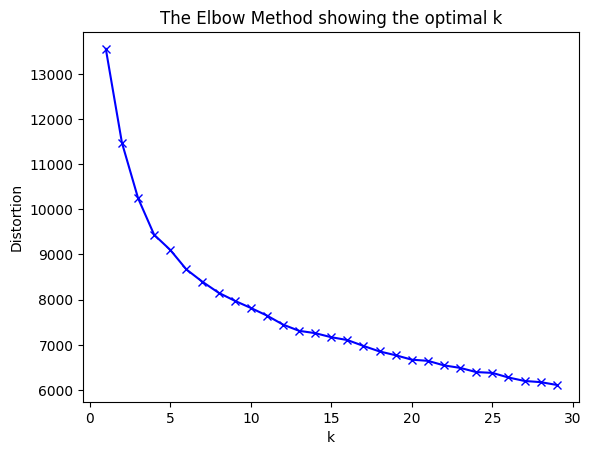

In [ ]:
elbow_plot = plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')


In [17]:
def kmeans_cluster_data(n_cluster: int, n_components: int, features):
    #reduce dimensionality
    pca = PCA(n_components=n_components)
    #convert images to numpy array
    features_flat = [image.flatten() for image in images]

    # Step 2: Create a 2D array by stacking the flattened features
    features_array = np.stack(features_flat, axis=0)

    features_reduced = pca.fit_transform(features_array)
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_cluster, random_state=42, max_iter=300, tol=1e-04)
    clustering = kmeans.fit_predict(features_reduced)
    return clustering, pca.components_

In [18]:
def dbscan_cluster_data (min_samples: int, n_components: int, features):
    #reduce dimensionality
    pca = PCA(n_components=n_components)
    #convert images to numpy array
    features_flat = [image.flatten() for image in images]

    # Step 2: Create a 2D array by stacking the flattened features
    features_array = np.stack(features_flat, axis=0)

    features_reduced = pca.fit_transform(features_array)
    # Apply K-Means clustering
    clustering = DBSCAN(eps=0.0005, min_samples=min_samples).fit_predict(features_reduced)
    return clustering, pca.components_

In [19]:
#cluster images based on their color feature space
#RGB image
image_disease_clustering, rgb_components = kmeans_cluster_data(n_disesases, n_components, images)
hsv_images  = [cv2.cvtColor(image, cv2.COLOR_BGR2HSV) for image in images]
hsv_disease_clustering, hsv_components = kmeans_cluster_data(n_disesases, n_components, hsv_images)
#lab image
lab_images = [cv2.cvtColor(image, cv2.COLOR_BGR2LAB) for image in images]
lab_disease_clustering, lab_components = kmeans_cluster_data(n_disesases, n_components, lab_images)
#YCrCb image
ycrcb_images  = [cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) for image in images]
ycrcb_disease_clustering, ycrb_components = kmeans_cluster_data(n_disesases, n_components, ycrcb_images)

c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change fr

In [20]:
#do the same clustering with number of clusters=number of datasets
image_dataset_clustering, image_components = kmeans_cluster_data(n_datasets, n_components, images)
hsv_dataset_clustering, hsv_components = kmeans_cluster_data(n_datasets, n_components, hsv_images)
#lab image
lab_dataset_clustering, lab_components = kmeans_cluster_data(n_datasets, n_components, lab_images)
#YCrCb image
ycrcb_dataset_clustering, ycrb_components = kmeans_cluster_data(n_datasets, n_components, ycrcb_images)

c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change fr

In [21]:
def cluster_label_correlation(cluster_values: list, labels : list):
    #create a column for every cluster and disease
    unique_labels = np.unique(labels)
    unique_cluster_values = np.unique(cluster_values)
    cluster_df = pd.DataFrame(columns=unique_labels)
    #create a column for every cluster
    for cluster in cluster_values:
        cluster_df[f'cluster_{cluster}'] = 0
    # Reset the index to make sure it starts from 0
        cluster_df.reset_index(drop=True, inplace=True)
    #the value of the cluster is 1 if the image belongs to that cluster else 0 same for labels
    #initialize default rows as many as there are labels
    for label in labels:
        #initialize all values to 0
        new_row = pd.DataFrame([[0] * len(cluster_df.columns)], columns=cluster_df.columns)
        cluster_df = pd.concat([cluster_df, new_row], ignore_index=True, axis=0)
    for i in range(len(labels)):
        cluster_df.at[i, labels[i]] = 1
        cluster_df.at[i,f'cluster_{cluster_values[i]}'] = 1
    #calculate correlation between clusters
    cluster_df = cluster_df.fillna(0)
    corr = cluster_df.corr()
    return corr, cluster_df

In [22]:
#plot correlation matrix
import seaborn as sns
def correlation_matrix(corr, title = 'Correlation Matrix'):
    cmap = "PiYG"
    center = 0
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap=cmap, center=center, xticklabels=1, yticklabels=1)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()
    #plot rfmid2 heatmap

In [23]:
def calculate_component_value(component, image):
    return np.sum(component * image.flatten())

In [24]:
#print number of diseases
print('number of diseases', n_disesases)

number of diseases 7


In [25]:
#reverse a dict function
def reverse_dict(dict_to_reverse):
    return {value: key for key, value in dict_to_reverse.items()}

In [26]:
#calculate the label cluster correlation for hsv, lab and ycrcb
hsv_disease_cluster_corr, hsv_disease_cluster_df = cluster_label_correlation(hsv_disease_clustering, images_df_no_normal['disease_key'].tolist())
lab_disease_cluster_corr, lab_disease_cluster_df = cluster_label_correlation(lab_disease_clustering, images_df_no_normal['disease_key'].tolist())
ycrcb_disease_cluster_corr, ycrb_disease_cluster_df = cluster_label_correlation(ycrcb_disease_clustering, images_df_no_normal['disease_key'].tolist())

#do the same for datasets
hsv_dataset_cluster_corr, hsv_dataset_cluster_df = cluster_label_correlation(hsv_dataset_clustering, images_df_no_normal['dataset_name'].tolist())
lab_dataset_cluster_corr, lab_dataset_cluster_df = cluster_label_correlation(lab_dataset_clustering, images_df_no_normal['dataset_name'].tolist())
ycrcb_dataset_cluster_corr, ycrb_dataset_cluster_df = cluster_label_correlation(ycrcb_dataset_clustering, images_df_no_normal['dataset_name'].tolist())


In [27]:
def plot_label_cluster_proportions(labels: list, clusters: list, xlabel : str, ylabel: str, title: str):
    df = pd.DataFrame({'cluster': clusters, 'label': labels})
    # Assuming df is your DataFrame, 'disease' is the column with diseases, and 'cluster' is the column with clusters
    counts = df.groupby(['label', 'cluster']).size().unstack(fill_value=0)
    print(counts)
    proportions = counts.divide(counts.sum(axis=1), axis=0)
    # Create a stacked bar chart
    ax = proportions.plot.bar(stacked=True, figsize=(30, 7))

    # Calculate the total counts for each disease
    total_counts = counts.sum(axis=0)

    # # Add the counts on top of each bar
    # for i, disease_count in enumerate(total_counts):
    #     ax.text(i, disease_count, str(disease_count), ha='center', va='bottom')


    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    return ax

cluster                                            0    1   2   3    4  5   6
disease                                                                      
Blur fundus with suspected PDR                     0    0   1   0    0  0   0
Blur fundus without PDR                            0    0   5   0    0  0   0
Central Serous Chorioretinopathy                   0    0   2   0    0  0   0
Cotton-wool spots                                  0    0   1   0    0  0   0
Disc swelling and elevation                        0    0   2   0    0  0   0
Large optic cup                                    0    0   3   0    0  0   0
Myelinated nerve fiber                             5    2   4   1    2  0   0
Normal                                            12  128  77  82  137  0  52
Peripheral retinal degeneration and break          0    0   1   0    0  0   0
Preretinal hemorrhage                              0    0   1   0    0  0   0
Retinal Artery Occlusion                           0    0   1   

NameError: name 'date' is not defined

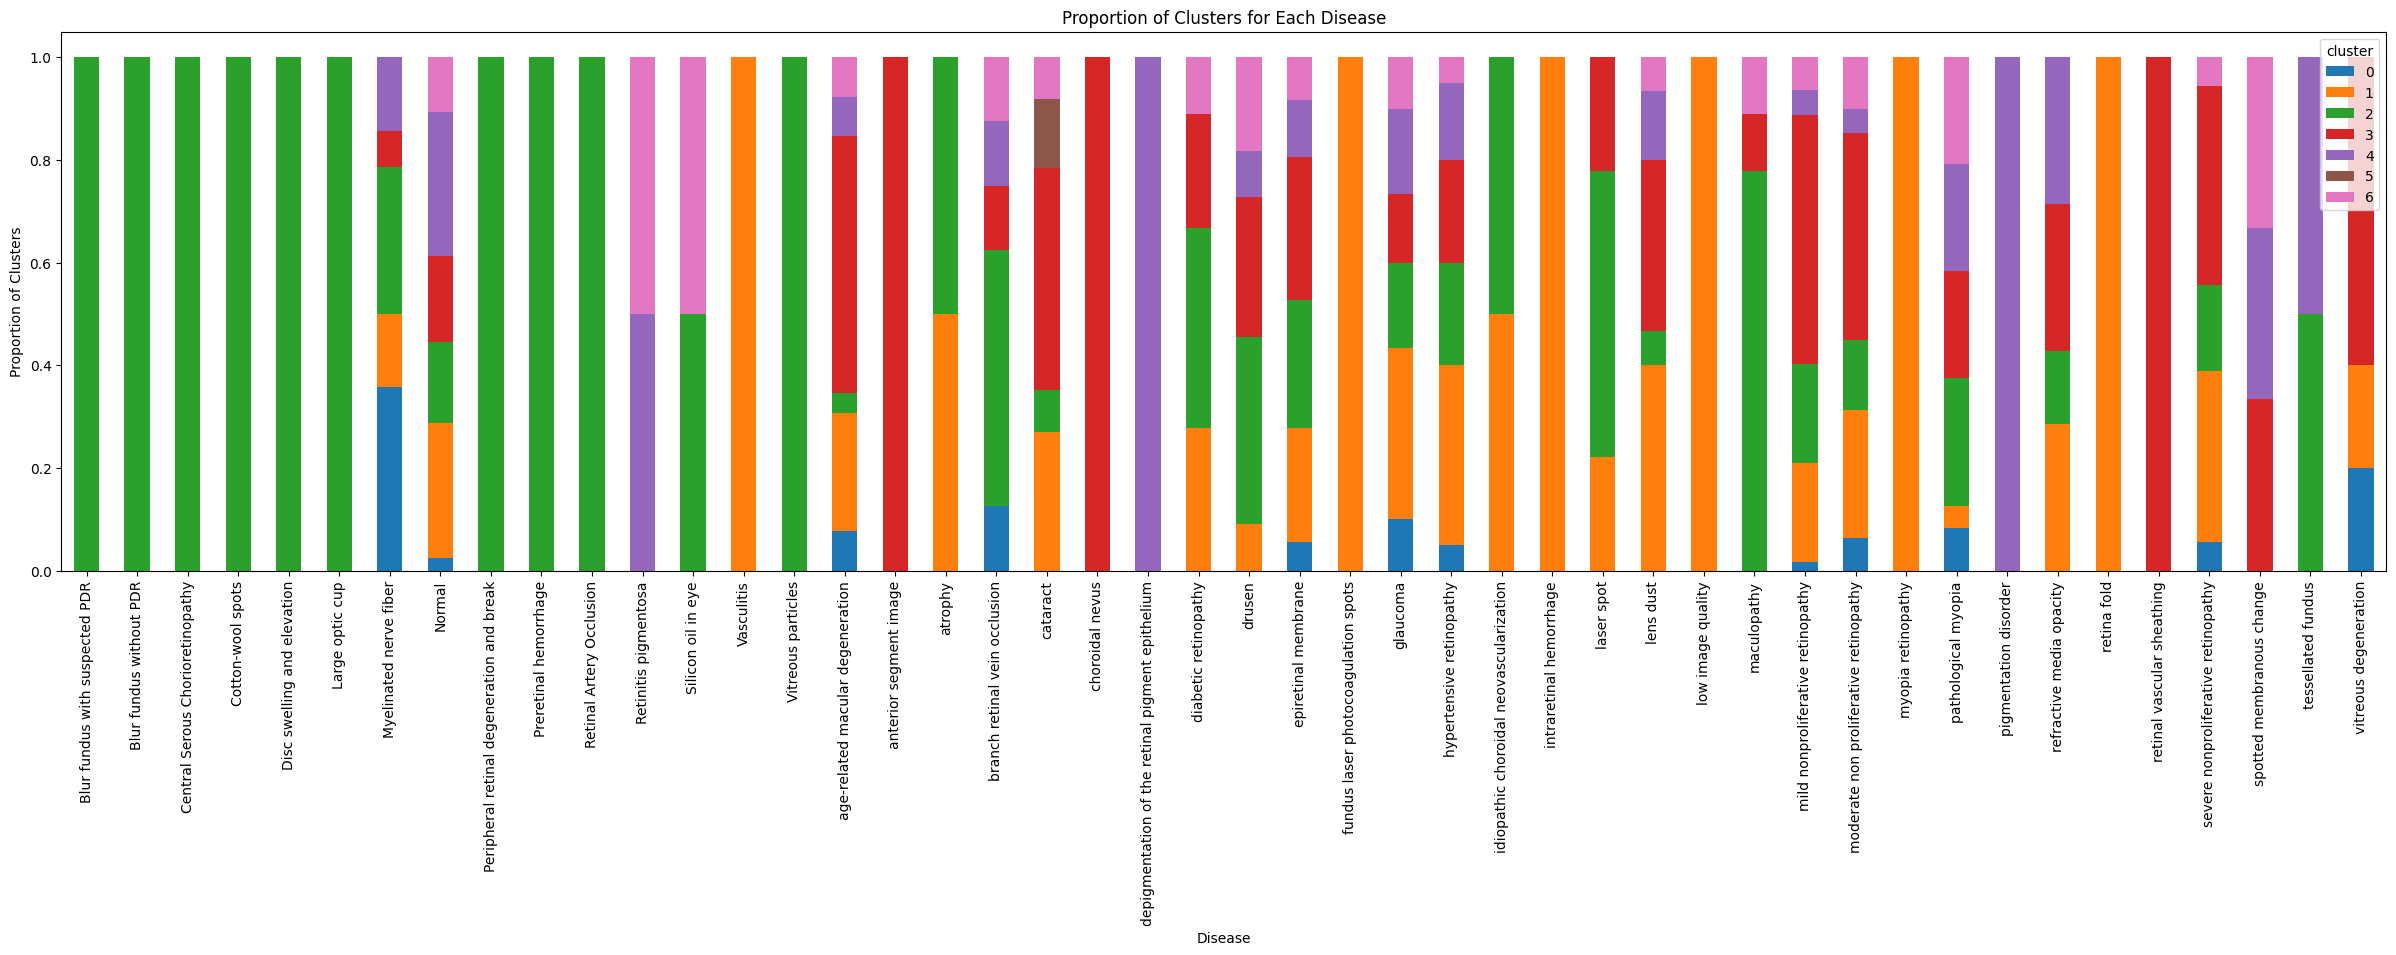

In [28]:
try_df = pd.DataFrame({'cluster': image_disease_clustering, 'disease': images_df_no_normal['disease_key'].tolist()})
# Assuming df is your DataFrame, 'disease' is the column with diseases, and 'cluster' is the column with clusters
counts = try_df.groupby(['disease', 'cluster']).size().unstack(fill_value=0)
print(counts)
proportions = counts.divide(counts.sum(axis=1), axis=0)
# Create a stacked bar chart
ax = proportions.plot.bar(stacked=True, figsize=(30, 7))

# Calculate the total counts for each disease
total_counts = counts.sum(axis=0)

# # Add the counts on top of each bar
# for i, disease_count in enumerate(total_counts):
#     ax.text(i, disease_count, str(disease_count), ha='center', va='bottom')


plt.xlabel('Disease')
plt.ylabel('Proportion of Clusters')
plt.title('Proportion of Clusters for Each Disease')
plt.savefig(f'proportion_clusters_disease_{n_disesases}_{date}.png')
plt.show()

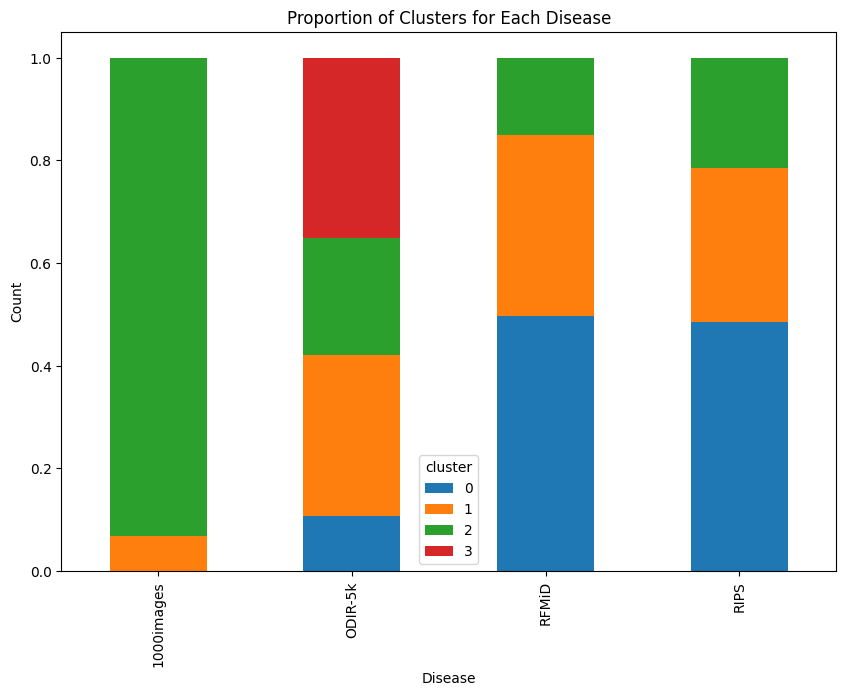

In [ ]:
try_df = pd.DataFrame({'cluster': image_dataset_clustering, 'disease': images_df_no_normal['dataset_name'].tolist()})
# Assuming df is your DataFrame, 'disease' is the column with diseases, and 'cluster' is the column with clusters
counts = try_df.groupby(['disease', 'cluster']).size().unstack(fill_value=0)
proportions = counts.divide(counts.sum(axis=1), axis=0)
# Create a stacked bar chart
proportions.plot.bar(stacked=True, figsize=(10, 7))

plt.xlabel('Disease')
plt.ylabel('Count')
plt.title('Proportion of Clusters for Each Disease')
plt.savefig(f'proportion_clusters_datasets_{n_datasets}_{date}.png')
plt.show()

In [29]:
#do hog feature extraction
hog_features = []
hog_images = []
gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]
from skimage.feature import hog
from skimage import exposure
for gray_image in gray_images:
    # Compute HOG features
    features, hog_image = hog(gray_image, orientations=8, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), visualize=True)

    # Enhance the contrast of the HOG image
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    hog_features.append(features)
    hog_images.append(hog_image_rescaled)


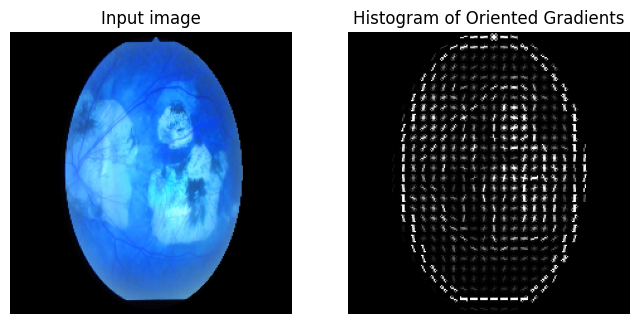

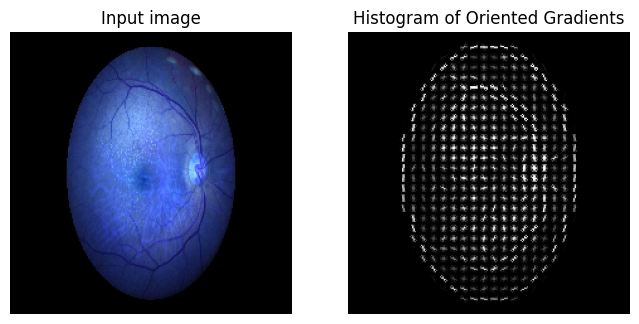

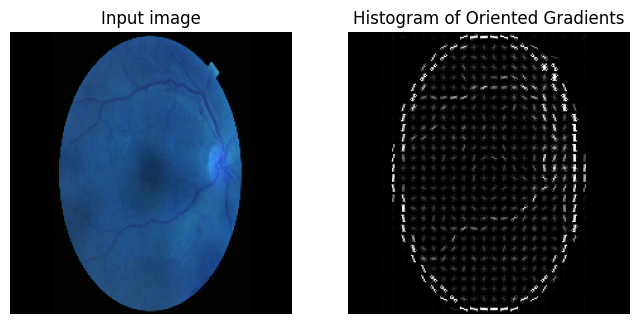

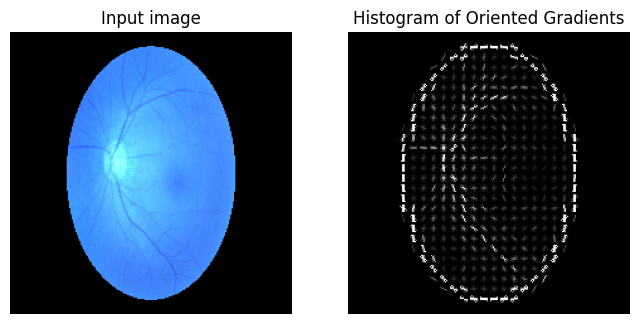

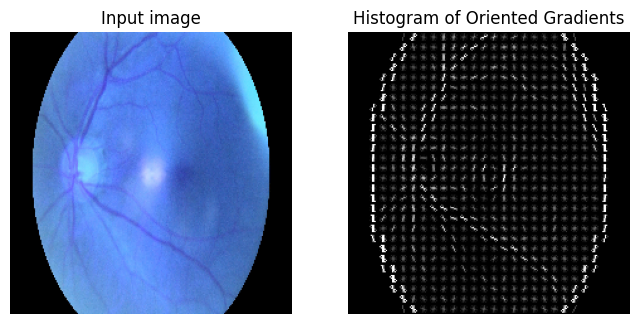

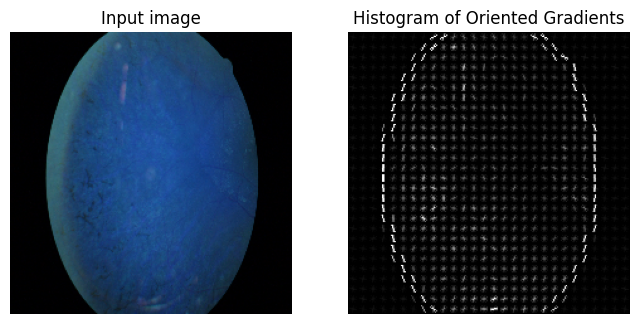

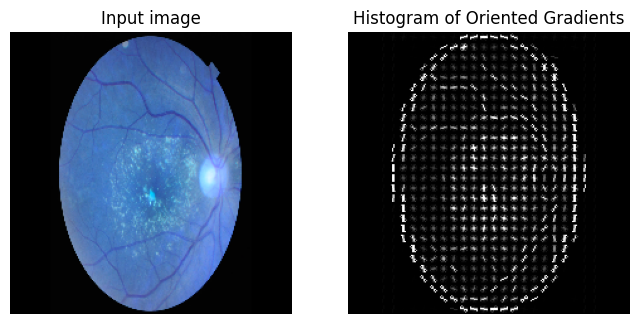

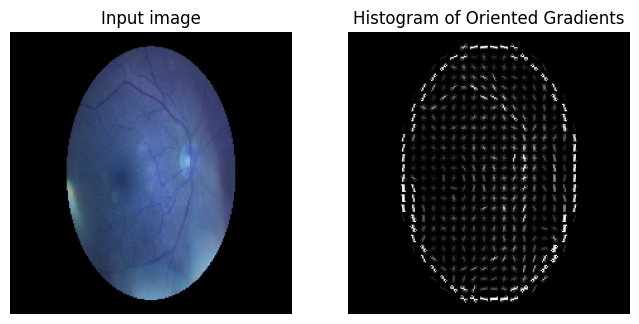

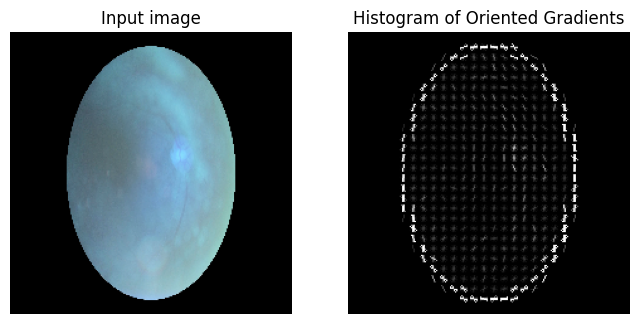

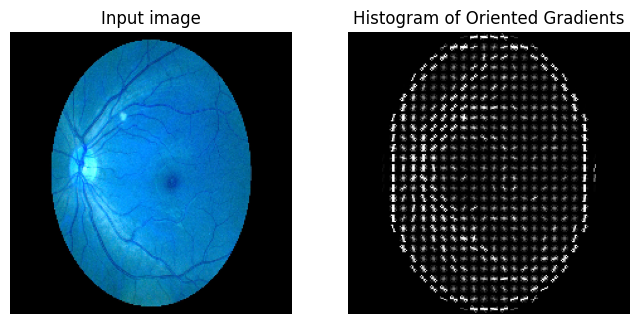

In [31]:
#visualize first 10 hog images
for i in range(10):
    #plot hog and original image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.axis('off')
    ax1.imshow(images[i], cmap=plt.cm.gray)
    ax1.set_title('Input image')
    ax2.axis('off')
    ax2.imshow(hog_images[i], cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')

In [ ]:
#elbow detection for hog features
hog_elbow = elbow_detection(hog_features, 16, 2, 10)

c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change fr

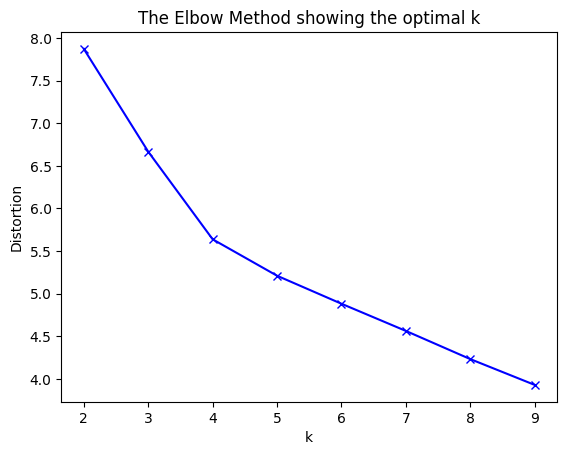

In [ ]:
plot_distortions(hog_elbow, 2, 10)
plt.savefig(f'hog_elbow_{date}.png')
plt.show()

In [ ]:
hog_elbow = 4

In [ ]:
#hog clustering
hog_disease_clustering, hog_components = kmeans_cluster_data(hog_elbow, n_components, hog_features)
hog_dataset_clustering, hog_components = kmeans_cluster_data(hog_elbow, n_components, hog_features)


c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\elyes\miniconda3\envs\ird\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


cluster                          0   1   2   3
label                                         
Bietti crystalline dystrophy     0   0   3   0
Blur fundus with suspected PDR   0   2  17   0
Blur fundus without PDR          0  18  50   0
Branch Retinal Vein Occlusion    1  16   3   8
Central Retinal Vein Occlusion   1   1   0   0
...                             ..  ..  ..  ..
vessel tortuosity                0   1  10   0
vitreous degeneration           10  14   9  32
vitreous opacity                 0   0   1   0
wedge white line change          0   1   0   0
white vessel                     1   4   4   3

[88 rows x 4 columns]


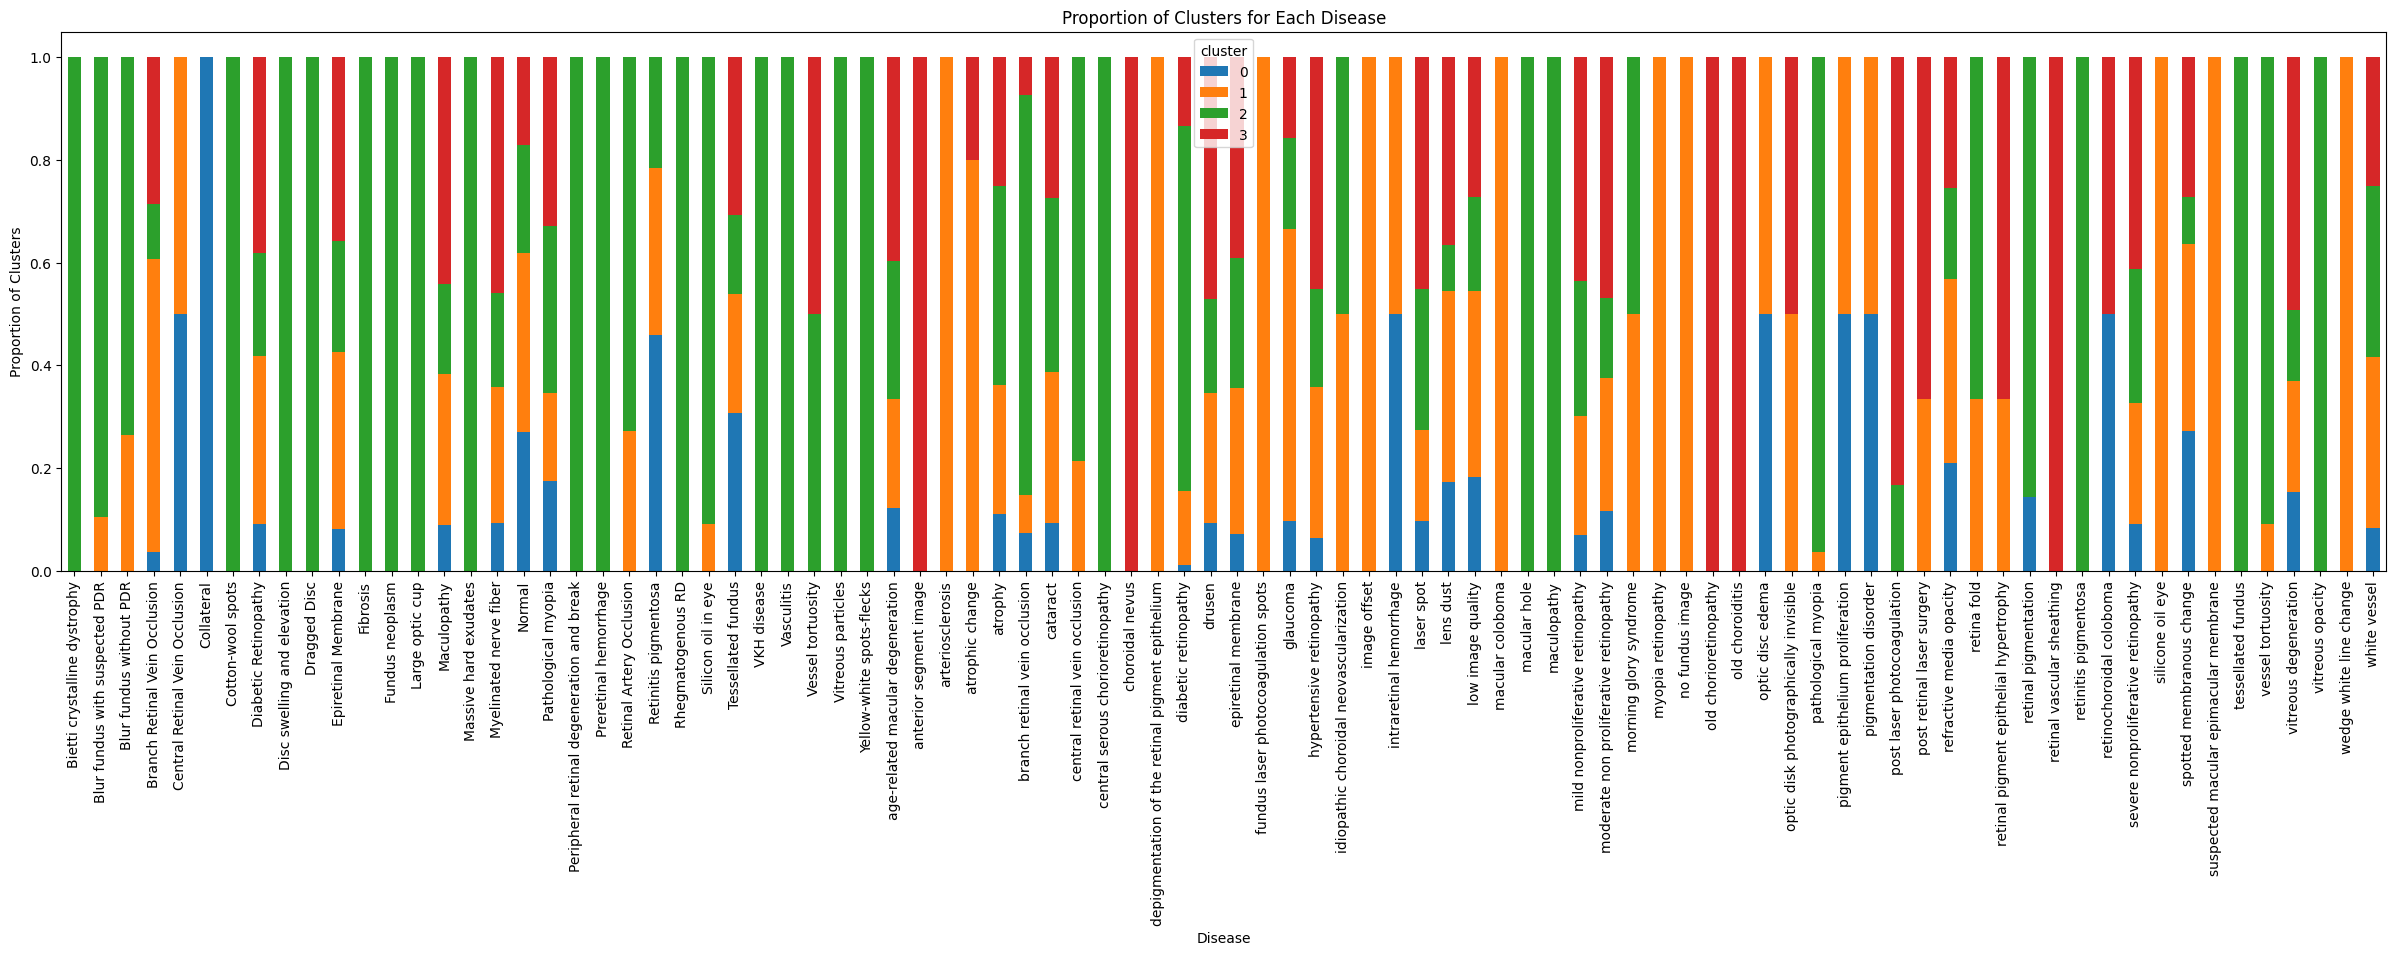

In [ ]:
#visualize hog clusters
plot_label_cluster_proportions(images_df_no_normal['disease_key'].tolist(), hog_disease_clustering, 'Disease', 'Proportion of Clusters', 'Proportion of Clusters for Each Disease')
plt.savefig(f'proportion_clusters_hog_disease_{hog_elbow}_{date}.png')
plt.show()

cluster        0     1     2     3
label                             
1000images     0    36   497     0
ODIR-5k      773  2281  1641  2549
RFMiD       1068   759   321     1
RIPS          34    21    15     0


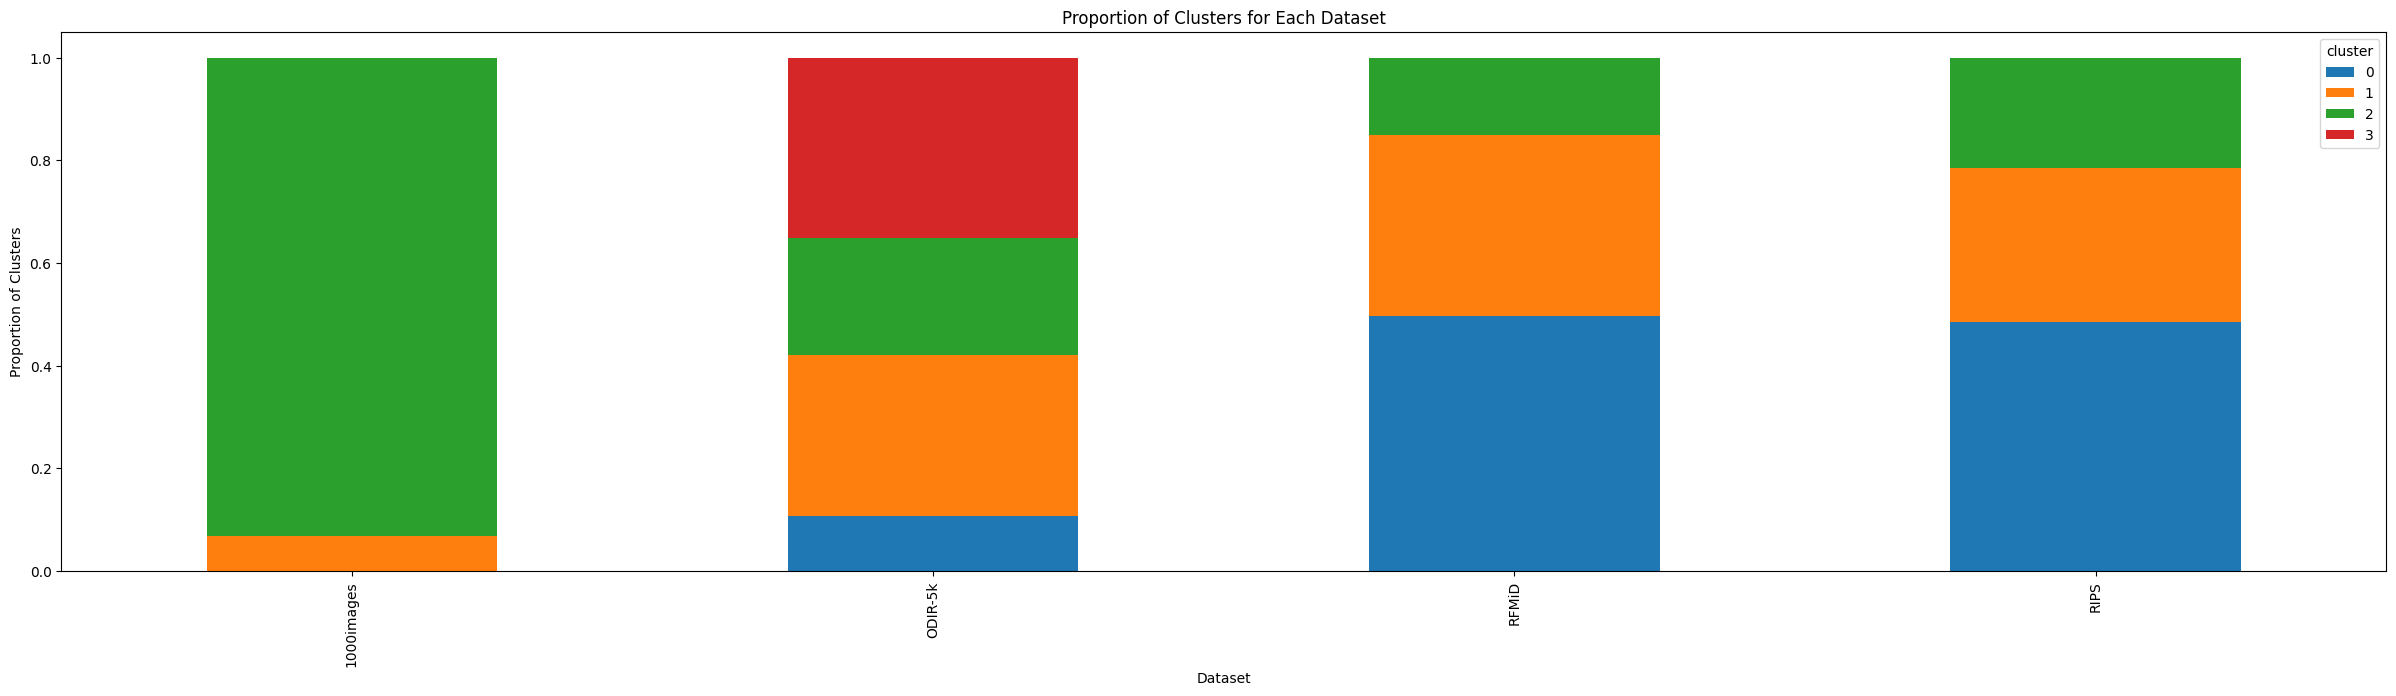

In [ ]:
#visualize hog clusters datasets
plot_label_cluster_proportions(images_df_no_normal['dataset_name'].tolist(), hog_dataset_clustering, 'Dataset', 'Proportion of Clusters', 'Proportion of Clusters for Each Dataset')
plt.savefig(f'proportion_clusters_hog_dataset_{hog_elbow}_{date}.png')
plt.show()